In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Sun May 16 22:14:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    37W / 250W |   2383MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torchvision
import torch.nn as nn                       #all neural network modules
import torch.nn.functional as F             #all functions that don't have parameters
import torch.optim as optim                 #all optimization algos such as SGD, Adam.
from torchvision import transforms,models
from torch.utils.data import random_split
import matplotlib.pyplot as plt

#MNIST - Method 1 (using Pytorch model library but pre-trained=False)

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels, and centered to reduce preprocessing and get started quicker.

In [3]:
"""Initialize the training and testing parameters."""

n_epochs = 10
learning_rate = 0.01
momentum = 0.9
batch_size_train = 256
batch_size_test = 1000

log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)


In [4]:
"""Downloading the MNIST dataset"""

train_loader = torch.utils.data.DataLoader( torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                            batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))])),
                            batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 1, 28, 28])

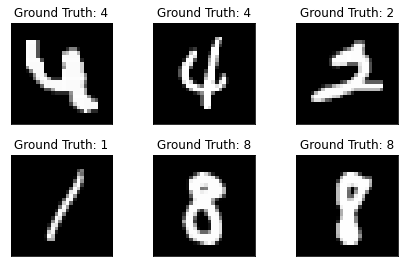

In [5]:
"""Visualizing some of the ground truth image."""
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig.show()

##ResNet

In [6]:
from torchvision.models import resnet50

model_rnet = resnet50(num_classes=10, pretrained=False)  #number of classes in MNIST is 10. This modifies the output features of the last FC layer.
model_rnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [7]:
model_rnet

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
optimizer = optim.SGD(model_rnet.parameters(), lr=learning_rate, momentum=momentum)

#optimizer = optim.Adam(model_rnet.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss()

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

if torch.cuda.is_available():
    model_rnet = model_rnet.cuda()      #push the parameters to default device.
    criterion = criterion.cuda()

We'll also keep track of the progress with some printouts. In order to create a nice training curve later on we also create two lists for saving training and testing losses. On the x-axis we want to display the number of training examples the network has seen during training.

In [9]:
train_losses_rnet = []
train_counter_rnet = []
test_losses_rnet = []
test_counter_rnet = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acc_rnet = []

Time to build our training loop. First we want to make sure our network is in training mode. Then we iterate over all training data once per epoch. Loading the individual batches is handled by the DataLoader. First we need to manually set the gradients to zero using `optimizer.zero_grad()` since PyTorch by default accumulates gradients. We then produce the output of our network (forward pass) and compute a negative log-likelihodd loss between the output and the ground truth label. The `backward()` call we now collect a new set of gradients which we propagate back into each of the network's parameters using `optimizer.step()`.

Neural network modules as well as optimizers have the ability to save and load their internal state using `.state_dict()`. With this we can continue training from previously saved state dicts if needed - we'd just need to call `.load_state_dict(state_dict). `

In [10]:
"""Training model function"""

def train(epoch):
  model_rnet.train()

  for batch_idx, (data, target) in enumerate(train_loader):
    #if GPU is available, move data and target to GPU
    if torch.cuda.is_available():
      data=data.cuda()
      target=target.cuda()
    
    #compute output and loss.    
    output = model_rnet(data)
    loss = criterion(output, target)

    #backward and update model.

    #In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    #This is convenient while training RNNs. So, the default action is to accumulate (i.e. sum) the gradients on every loss.backward() call.
    #Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
    #Else the gradient would point in some other direction than the intended direction towards the minimum (or maximum, in case of maximization objectives).

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      
      train_losses_rnet.append(loss.item())
      train_counter_rnet.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

      torch.save(model_rnet.state_dict(), '/resnetmodel.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')


"""Testing model function"""
def test():
  model_rnet.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:
      if torch.cuda.is_available():
        data=data.cuda()
        target=target.cuda()

      output = model_rnet(data)
      test_loss += criterion(output, target).item()

      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()

  test_loss /= len(test_loader.dataset)
  test_losses_rnet.append(test_loss)
  test_acc = 100 * correct / len(test_loader.dataset)
  test_acc_rnet.append(test_acc)

  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
  


In [11]:
"""Training and testing results at each epoch"""

epochs=[]
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
  epochs.append(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.638046
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.422322
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.530058
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.774783
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.387177
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.408805
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.527612
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.222846
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.187388
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.334475
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.147176
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.261269
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.093196
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.119685
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.109278
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.140935
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.132702
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.121755
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.085151
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.145794
Train Epoc

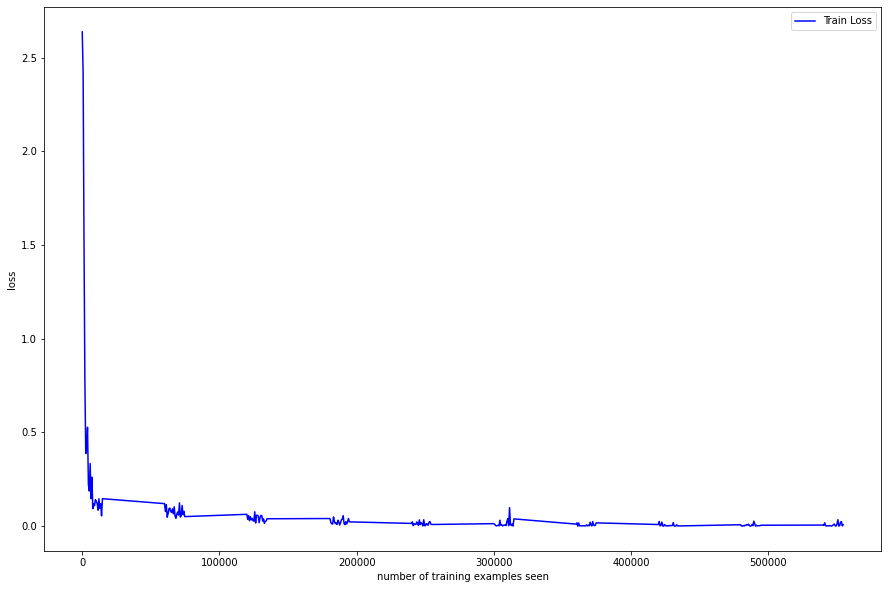

In [12]:
"""Ploting loss curve """

fig = plt.figure(figsize=(15,10))
plt.plot(train_counter_rnet, train_losses_rnet, color='blue')
plt.legend(['Train Loss','Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')
fig.show()

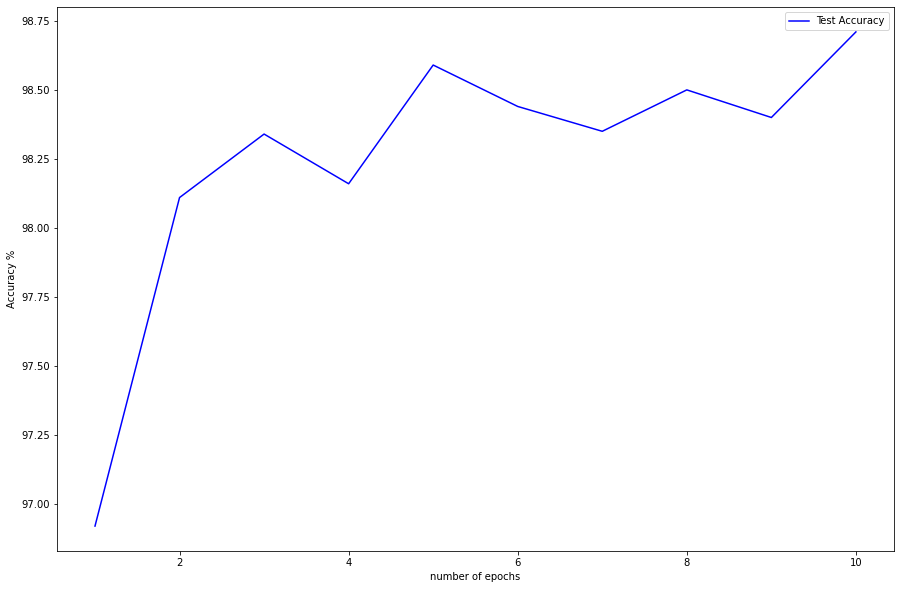

In [13]:
"""Plotting accuracy curve"""

fig = plt.figure(figsize=(15,10))
plt.plot(epochs, test_acc_rnet, color='blue')
plt.legend(['Test Accuracy'], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy %')
fig.show()

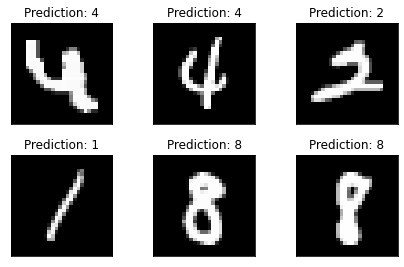

In [14]:
"""Visualizing predictions"""

with torch.no_grad():
  example_data=example_data.cuda()
  output = model_rnet(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0].cpu(), cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig.show()

##GoogLeNet

In [15]:
from torchvision.models import googlenet

model_gnet = googlenet(num_classes=10)
model_gnet.conv1.conv = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_gnet

/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:79: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [16]:
optimizer = optim.SGD(model_gnet.parameters(), lr=learning_rate,momentum=momentum)
#optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model_gnet = model_gnet.cuda()      #push the parameters to default device.
    criterion = criterion.cuda()

In [17]:
train_losses_gnet = []
train_counter_gnet = []
test_losses_gnet = []
test_counter_gnet = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
test_acc_gnet = []

In [18]:
"""Training function"""
def train(epoch):
  model_gnet.train()

  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data=data.cuda()
    target=target.cuda()
    
    output = model_gnet(data)
    loss = criterion(output.logits, target)
    
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
      train_losses_gnet.append(loss.item())
      train_counter_gnet.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model_gnet.state_dict(), '/googlenetmodel.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

"""Testing function"""

def test():
  model_gnet.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data=data.cuda()
      target=target.cuda()
      output = model_gnet(data)
      test_loss += criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses_gnet.append(test_loss)
  test_acc = 100 * correct / len(test_loader.dataset)
  test_acc_gnet.append(test_acc)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [19]:

epochs=[]
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
  epochs.append(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324895
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.439751
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.485044
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.453181
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.217592
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.243916
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.180156
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.107031
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.109809
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.096678
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.110614
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.118690
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.101113
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.141623
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.074521
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.116602
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.141475
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.140381
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.126723
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.121306
Train Epoc

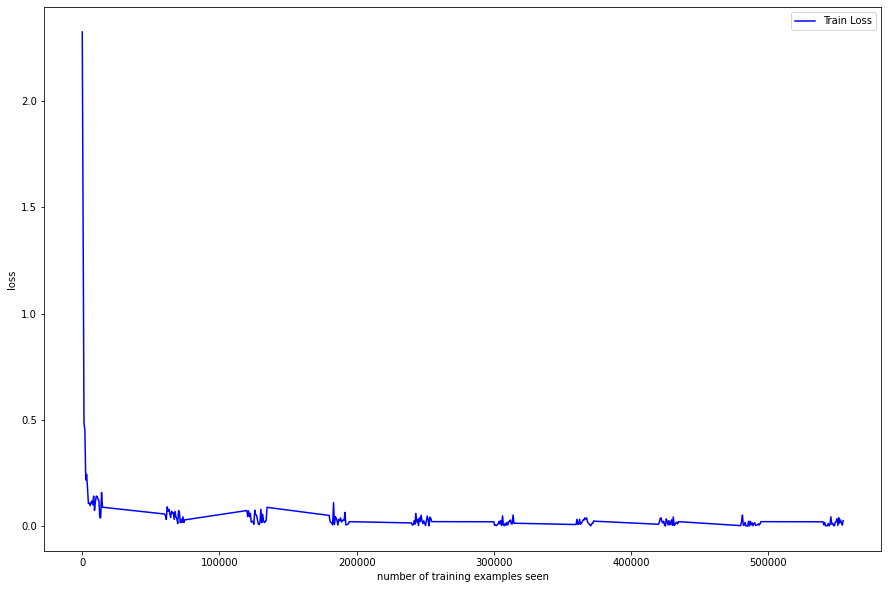

In [20]:
"""Ploting loss curve """

fig = plt.figure(figsize=(15,10))
plt.plot(train_counter_gnet, train_losses_gnet, color='blue')
plt.legend(['Train Loss','Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('loss')
fig.show()

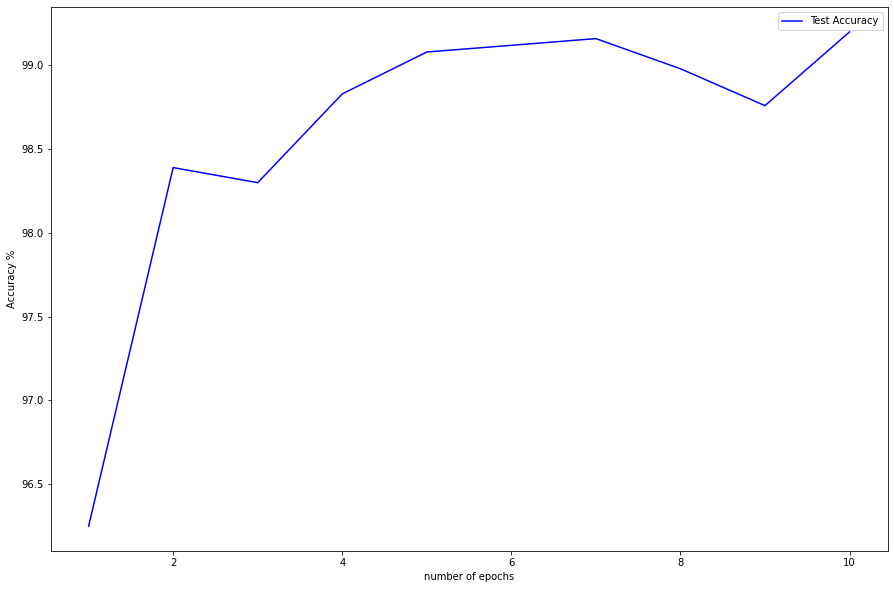

In [21]:
"""Plotting accuracy curve"""

fig = plt.figure(figsize=(15,10))
plt.plot(epochs, test_acc_gnet, color='blue')
plt.legend(['Test Accuracy'], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy %')
fig.show()

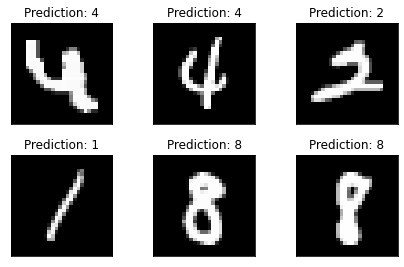

In [22]:
"""Visualizing predictions"""

with torch.no_grad():
  example_data=example_data.cuda()
  output = model_gnet(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0].cpu(), cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig.show()

#MNIST - Method 2

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [4]:
BATCH_SIZE = 128 

# define tranforms on the training set
# include resizing and random rotations
train_transform = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.ToTensor(),
                                      # normalize using pretrained values
                                      transforms.Normalize((0.1307,), (0.3081,))])
# define transforms on the test set
test_transform = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     # normalize using pretrained values
                                     transforms.Normalize((0.1307,), (0.3081,))])
# load the data
train = datasets.MNIST(root='./data', train=True, download=True, transform = train_transform)
test = datasets.MNIST(root='./data', train=False, download=True, transform = test_transform)

# percentage of the training data to be used in training
TRAIN_VAL_RATIO = 0.95

n_train_examples = int(len(train) * TRAIN_VAL_RATIO)
n_valid_examples = len(train) - n_train_examples

train, val = torch.utils.data.random_split(train, [n_train_examples, n_valid_examples])

# applying the transform on validation set
val = copy.deepcopy(val)
val.dataset.transform = test_transform

# defining appropriate dataloaders
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle=False)

In [56]:

VGG_architectures = {
    'VGG13': [64, 64, 'pool', 128, 128, 'pool', 256, 256, 'pool', 512, 512, 'pool', 512, 512, 'pool'],
    'VGG16': [64, 64, 'pool', 128, 128, 'pool', 256, 256, 256, 'pool', 512, 512, 512, 'pool', 512, 512, 512, 'pool']
}

class VGG(nn.Module):
  '''
  Implementation of VGG with Batch Norm for MNIST and CIFAR

  num_classes (int): number of existing classes in data
  '''
  def __init__(self, in_planes = 1, num_classes = 10):
    super(VGG, self).__init__()
    self.in_planes = in_planes
    # using the stack layers function - define which architecture the model should use
    self.convs = self.stack_layers(VGG_architectures['VGG13'])

    self.fully_connected = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(inplace = True),
        nn.Dropout(0.2),
        nn.Linear(128, 128),
        nn.ReLU(inplace = True),
        nn.Dropout(0.2),
        nn.Linear(128, num_classes)
    )

  def stack_layers(self, architecture):
    in_planes = self.in_planes
    stack = []

    for layer in architecture:
      if type(layer) == int:
        out = layer
        stack += [nn.Conv2d(in_planes, out, kernel_size = 3, stride = 1, padding = 1),
                  # use Batch Normalization here
                  nn.BatchNorm2d(layer),
                  nn.ReLU(inplace = True)]
        in_planes = layer
      else:
        stack += [nn.MaxPool2d(kernel_size = 2)]
      
    return nn.Sequential(*stack)

  def forward(self, x):
    x = self.convs(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fully_connected(x)

    return x

In [71]:
class ResNetBlock(nn.Module):
    '''
    A class for a Basic ResNet Block to be used in the ResNet class
    Suited only for CIFAR10 and MNIST

    in_planes (int): number of input channels
    planes (int): number of output channels
    stride (int): stride of the convolutional layer
    '''
    def __init__(self, in_planes, planes, stride=1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
              nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(planes)
              )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
        
class ResNet(nn.Module):
    '''
    ResNet Class, building on a ResNet Block to make a full network

    num_blocks (int):       multiplier used to stack layers, 
                            total number of layers is 6*num_blocks + 2
    channels (int):         number of colour_channels present in data
    num_classes (int):      number of existing classes in data
    '''
    def __init__(self, block, num_blocks, channels, num_classes):
        super(ResNet, self).__init__()
        # initialize number of output channels at 16
        self.in_planes = 16

        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.stack_layer(block, 16, num_blocks, stride=1)
        self.layer2 = self.stack_layer(block, 32, num_blocks, stride=2)
        self.layer3 = self.stack_layer(block, 64, num_blocks, stride=2)
        self.linear = nn.Linear(64, num_classes)
    
    def stack_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            # update the number of output channels
            self.in_planes = planes 

        return nn.Sequential(*layers)

    def forward(self, x):
        # creating the network
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        # reshaping
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def resnet20():
    return ResNet(ResNetBlock, num_blocks = 3, channels = 1, num_classes = 10)

def resnet44():
    return ResNet(ResNetBlock, 7, channels = 1, num_classes = 10)

In [5]:
def conv_relu(in_channels, out_channels, kernel, stride=1, padding=0):
    layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
        nn.BatchNorm2d(out_channels, eps=1e-3),
        nn.ReLU(True))
    return layer

class Inception(nn.Module):
    def __init__(self,in_channel,c1,c2,c3,c4):
        super(Inception,self).__init__()
        self.norm1_1=nn.BatchNorm2d(in_channel,eps=1e-3)
        self.p1_1=nn.Conv2d(in_channels=in_channel,out_channels=c1,kernel_size=1)
        self.norm2_1 = nn.BatchNorm2d(in_channel, eps=1e-3)
        self.p2_1=nn.Conv2d(in_channels=in_channel,out_channels=c2[0],kernel_size=1)
        self.norm2_2 = nn.BatchNorm2d(c2[0], eps=1e-3)
        self.p2_2=nn.Conv2d(in_channels=c2[0],out_channels=c2[1],kernel_size=3,padding=1)
        self.norm3_1 = nn.BatchNorm2d(in_channel, eps=1e-3)
        self.p3_1=nn.Conv2d(in_channels=in_channel,out_channels=c3[0],kernel_size=1)
        self.norm3_2 = nn.BatchNorm2d(c3[0], eps=1e-3)
        self.p3_2=nn.Conv2d(in_channels=c3[0],out_channels=c3[1],kernel_size=5,padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.norm4_2 = nn.BatchNorm2d(in_channel, eps=1e-3)
        self.p4_2 = nn.Conv2d(in_channels=in_channel, out_channels=c4, kernel_size=1)
 
    def forward(self, x):
        p1=self.p1_1(F.relu(self.norm1_1(x)))
        p2=self.p2_2(F.relu(self.norm2_2(self.p2_1(F.relu(self.norm2_1(x))))))
        p3=self.p3_2(F.relu(self.norm3_2(self.p3_1(F.relu(self.norm3_1(x))))))
        p4=self.p4_2(F.relu(self.norm4_2(self.p4_1(x))))
        return torch.cat((p1,p2,p3,p4),dim=1)

class GoogleNet(nn.Module):
    def __init__(self,in_channel=1,num_classes=10):
        super(GoogleNet,self).__init__()
        layers=[]
        layers+=[nn.Conv2d(in_channels=in_channel,out_channels=64,kernel_size=7,stride=2,padding=3),
                 nn.ReLU(),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1)]
        layers+=[nn.Conv2d(in_channels=64,out_channels=64,kernel_size=1), nn.ReLU(),
                 nn.Conv2d(in_channels=64,out_channels=192,kernel_size=3,padding=1),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1)]
        layers+=[Inception(192,64,(96,128),(16,32),32),
                 Inception(256,128,(128,192),(32,96),64),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1)]
        layers+=[Inception(480, 192, (96, 208), (16, 48), 64),
                 Inception(512, 160, (112, 224), (24, 64), 64),
                 Inception(512, 128, (128, 256), (24, 64), 64),
                 Inception(512, 112, (144, 288), (32, 64), 64),
                 Inception(528, 256, (160, 320), (32, 128), 128),
               nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        layers += [Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   #nn.AvgPool2d(kernel_size=2)]
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten()]
        self.net = nn.Sequential(*layers)
        self.dense=nn.Linear(1024,num_classes)
 
    def forward(self,x):
        x=self.net(x)
        x=x.view(-1,1024*1*1)
        x=self.dense(x)
        return x


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#uncomment the model to be used.

#model = VGG(in_planes=1,num_classes=10).to(device)

#model = resnet20().to(device)

model = GoogleNet().to(device)

model

GoogleNet(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): Inception(
      (norm1_1): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (norm2_1): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (norm2_2): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm3_1): BatchNorm2d(192, e

In [11]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9, weight_decay=0.0005)
# scheduler for VGG
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[10, 20], last_epoch= -1)

# scheduler for ResNet
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[8,15], last_epoch= -1)

In [8]:
def calculate_accuracy(y_pred, y):
    '''get model accuracy'''
    p = y_pred.argmax(1, keepdim = True)
    acc = p.eq(y.view_as(p)).sum().float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    '''
    function to be called for training and collect 
    model loss and model accuracy
    and perform a training step

    iterator: DataLoader Object
    optimizer: Optimizer type
    criterion: loss type
    '''
    epoch_loss = 0
    epoch_acc = 0
    
    # set to training mode
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        # update loss and accuracy values
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    '''
    function to be called for evaluating and collect 
    model val loss and model val accuracy

    iterator: DataLoader Object
    optimizer: Optimizer type
    criterion: loss type
    '''
    epoch_loss = 0
    epoch_acc = 0
    
    # evaluation mode
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [12]:
EPOCHS = 20
train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []
for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    scheduler.step()
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    end_time = time.time()

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'epoch: {epoch+1:02}, Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t train accuracy: {train_acc:.3f} | train loss: {train_loss:.3f} | ')
    print(f'\t val accuracy: {val_acc:.3f} | val accuracy: {val_loss:.3f}')

epoch: 01, Time: 0m 35s
	 train accuracy: 0.980 | train loss: 0.078 | 
	 val accuracy: 0.981 | val accuracy: 0.066
epoch: 02, Time: 0m 35s
	 train accuracy: 0.982 | train loss: 0.067 | 
	 val accuracy: 0.976 | val accuracy: 0.088
epoch: 03, Time: 0m 35s
	 train accuracy: 0.985 | train loss: 0.057 | 
	 val accuracy: 0.977 | val accuracy: 0.086
epoch: 04, Time: 0m 35s
	 train accuracy: 0.985 | train loss: 0.060 | 
	 val accuracy: 0.985 | val accuracy: 0.043
epoch: 05, Time: 0m 35s
	 train accuracy: 0.984 | train loss: 0.059 | 
	 val accuracy: 0.986 | val accuracy: 0.051
epoch: 06, Time: 0m 35s
	 train accuracy: 0.985 | train loss: 0.055 | 
	 val accuracy: 0.982 | val accuracy: 0.058
epoch: 07, Time: 0m 34s
	 train accuracy: 0.985 | train loss: 0.056 | 
	 val accuracy: 0.948 | val accuracy: 0.179
epoch: 08, Time: 0m 34s
	 train accuracy: 0.987 | train loss: 0.050 | 
	 val accuracy: 0.979 | val accuracy: 0.071
epoch: 09, Time: 0m 34s
	 train accuracy: 0.988 | train loss: 0.045 | 
	 val acc

In [13]:
def get_preds(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [14]:
images, labels, probs = get_preds(model, test_loader)
pred_labels = torch.argmax(probs, 1)

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

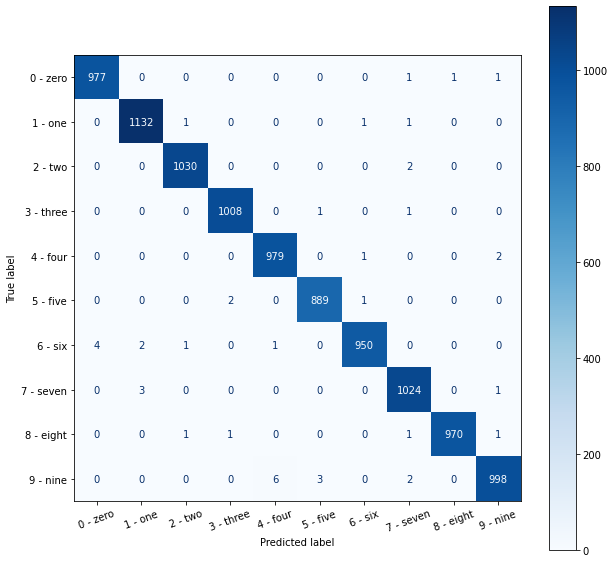

In [16]:
classes = test.classes

plot_confusion_matrix(labels, pred_labels, classes)

Text(0.5, 1.0, 'GoogLeNet, Cross Entropy Loss across Epochs')

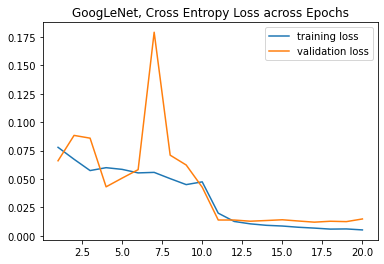

In [17]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_loss_list, label = 'training loss')
plt.plot([i for i in range(1,EPOCHS + 1)], val_loss_list, label = 'validation loss')
plt.legend()
plt.title('GoogLeNet, Cross Entropy Loss across Epochs')  #change model name to be used.

Text(0.5, 1.0, 'GoogLeNet, Accuracy across Epochs')

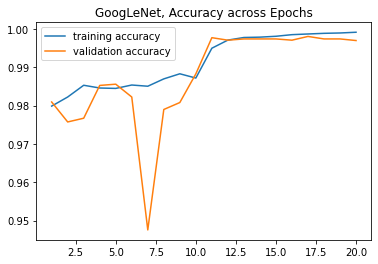

In [18]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_acc_list, label = 'training accuracy')
plt.plot([i for i in range(1,EPOCHS + 1)], val_acc_list, label = 'validation accuracy')
plt.legend()
plt.title('GoogLeNet, Accuracy across Epochs')

In [19]:
def labels_accuracy(y, y_pred):
  crr = 0
  for i in range(len(y)):
    if y[i] == y_pred[i]:
      crr += 1
  return crr/len(y)


labels_accuracy(labels.numpy(), pred_labels.numpy())

0.9957

In [20]:
correct_pred = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, correct_pred):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [21]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

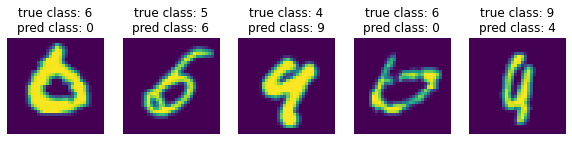

In [22]:
def show_incorrect_preds(incorrect, classes, n_images, normalize = False):

    rows = 1 
    cols = n_images  

    fig = plt.figure(figsize = (10, 10))
    fig.tight_layout()
    for i in range(cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image[0]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label][0]
        incorrect_class = classes[incorrect_label][0]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true class: {true_class}\n' \
                     f'pred class: {incorrect_class}')
        ax.axis('off')

show_incorrect_preds(incorrect_examples, classes, 5)

#CIFAR-10 dataset

##ResNet, VGG and GoogLeNet for CIFAR-10.

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [3]:
# using pretrained means to normalize the dataset
pretrained_means = [0.4914, 0.4822, 0.4465]
pretrained_stds= [0.247, 0.243, 0.261]
BATCH_SIZE = 100

# define tranforms on the training set
# include resizing and horizontal flip
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = pretrained_means,
                                                     std = pretrained_stds)])
# load the data
train = datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)
test = datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)

# percentage of the training data to be used in training
TRAIN_VAL_RATIO = 0.90

n_train_examples = int(len(train) * TRAIN_VAL_RATIO)
n_valid_examples = len(train) - n_train_examples

train, val = torch.utils.data.random_split(train, [n_train_examples, n_valid_examples])

# applying the transform on validation set
val = copy.deepcopy(val)
val.dataset.transform = transform

# defining appropriate dataloaders
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle=False)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:

VGG_architectures = {
    'VGG13': [64, 64, 'pool', 128, 128, 'pool', 256, 256, 'pool', 512, 512, 'pool', 512, 512, 'pool'],
    'VGG16': [64, 64, 'pool', 128, 128, 'pool', 256, 256, 256, 'pool', 512, 512, 512, 'pool', 512, 512, 512, 'pool']
}

class VGG(nn.Module):
  '''
  Implementation of VGG with Batch Norm for MNIST and CIFAR

  num_classes (int): number of existing classes in data
  '''
  def __init__(self, in_planes = 1, num_classes = 10):
    super(VGG, self).__init__()
    self.in_planes = in_planes
    # using the stack layers function - define which architecture the model should use
    self.convs = self.stack_layers(VGG_architectures['VGG16'])

    self.fully_connected = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(inplace = True),
        nn.Dropout(0.2),
        nn.Linear(128, 128),
        nn.ReLU(inplace = True),
        nn.Dropout(0.2),
        nn.Linear(128, num_classes)
    )

  def stack_layers(self, architecture):
    in_planes = self.in_planes
    # initialize empty list for all layers to be added
    stack = []

    for layer in architecture:
      if type(layer) == int:
        out = layer
        stack += [nn.Conv2d(in_planes, out, kernel_size = 3, stride = 1, padding = 1),
                  # use Batch Normalization here
                  nn.BatchNorm2d(layer),
                  nn.ReLU(inplace = True)]
        in_planes = layer
      else:
        stack += [nn.MaxPool2d(kernel_size = 2)]
      
    return nn.Sequential(*stack)

  def forward(self, x):
    # bringing together all parts of the network here
    x = self.convs(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fully_connected(x)

    return x

In [4]:
class ResNetBlock(nn.Module):
    '''
    A class for a Basic ResNet Block to be used in the ResNet class
    Suited only for CIFAR10 and MNIST

    in_planes (int): number of input channels
    planes (int): number of output channels
    stride (int): stride of the convolutional layer
    '''
    def __init__(self, in_planes, planes, stride=1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
              nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(planes)
              )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
        
class ResNet(nn.Module):
    '''
    ResNet Class, building on a ResNet Block to make a full network

    num_blocks (int):       multiplier used to stack layers, 
                            total number of layers is 6*num_blocks + 2
    channels (int):         number of colour_channels present in data
    num_classes (int):      number of existing classes in data
    '''
    def __init__(self, block, num_blocks, channels, num_classes):
        super(ResNet, self).__init__()
        # initialize number of output channels at 16
        self.in_planes = 16

        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.stack_layer(block, 16, num_blocks, stride=1)
        self.layer2 = self.stack_layer(block, 32, num_blocks, stride=2)
        self.layer3 = self.stack_layer(block, 64, num_blocks, stride=2)
        self.linear = nn.Linear(64, num_classes)
    
    def stack_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            # update the number of output channels
            self.in_planes = planes 

        return nn.Sequential(*layers)

    def forward(self, x):
        # creating the network
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        # reshaping
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def resnet20():
    return ResNet(ResNetBlock, num_blocks = 3, channels = 3, num_classes = 10)


def resnet44():
    return ResNet(ResNetBlock, num_blocks = 7, channels = 3, num_classes = 10)

In [20]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# umcomment a model to use here

#model = VGG(in_planes=3,num_classes=10).to(device)

model = resnet20().to(device)

#model = resnet44().to(device)

#model = GoogLeNet().to(device)

print(model)

summary(model, (3, 32, 32))

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResNetBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

In [7]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay=0.0001)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=0.0001)
# scheduler for VGG
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[10], last_epoch= -1)

# scheduler for ResNet
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[100, 150], last_epoch= -1)

In [8]:
def calculate_accuracy(y_pred, y):
    '''get model accuracy'''
    p = y_pred.argmax(1, keepdim = True)
    acc = p.eq(y.view_as(p)).sum().float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    '''
    function to be called for training and collect 
    model loss and model accuracy
    and perform a training step

    iterator: DataLoader Object
    optimizer: Optimizer type
    criterion: loss type
    '''
    epoch_loss = 0
    epoch_acc = 0
    
    # set to training mode
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        # update loss and accuracy values
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    '''
    function to be called for evaluating and collect 
    model val loss and model val accuracy

    iterator: DataLoader Object
    optimizer: Optimizer type
    criterion: loss type
    '''
    epoch_loss = 0
    epoch_acc = 0
    
    # evaluation mode
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [9]:
EPOCHS = 20
train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []
for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    scheduler.step()
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    end_time = time.time()

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'epoch: {epoch+1:02}, Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t train accuracy: {train_acc:.3f} | train loss: {train_loss:.3f} | ')
    print(f'\t val accuracy: {val_acc:.3f} | val accuracy: {val_loss:.3f}')

epoch: 01, Time: 1m 12s
	 train accuracy: 0.092 | train loss: 3.935 | 
	 val accuracy: 0.155 | val accuracy: 3.515
epoch: 02, Time: 1m 12s
	 train accuracy: 0.202 | train loss: 3.241 | 
	 val accuracy: 0.271 | val accuracy: 2.897
epoch: 03, Time: 1m 12s
	 train accuracy: 0.290 | train loss: 2.764 | 
	 val accuracy: 0.357 | val accuracy: 2.461
epoch: 04, Time: 1m 11s
	 train accuracy: 0.362 | train loss: 2.403 | 
	 val accuracy: 0.388 | val accuracy: 2.340
epoch: 05, Time: 1m 12s
	 train accuracy: 0.421 | train loss: 2.143 | 
	 val accuracy: 0.443 | val accuracy: 2.125
epoch: 06, Time: 1m 12s
	 train accuracy: 0.465 | train loss: 1.940 | 
	 val accuracy: 0.486 | val accuracy: 1.916
epoch: 07, Time: 1m 11s
	 train accuracy: 0.505 | train loss: 1.779 | 
	 val accuracy: 0.513 | val accuracy: 1.777
epoch: 08, Time: 1m 12s
	 train accuracy: 0.542 | train loss: 1.635 | 
	 val accuracy: 0.536 | val accuracy: 1.681
epoch: 09, Time: 1m 12s
	 train accuracy: 0.568 | train loss: 1.529 | 
	 val acc

In [10]:
def get_preds(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [11]:
images, labels, probs = get_preds(model, test_loader)
pred_labels = torch.argmax(probs, 1)

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

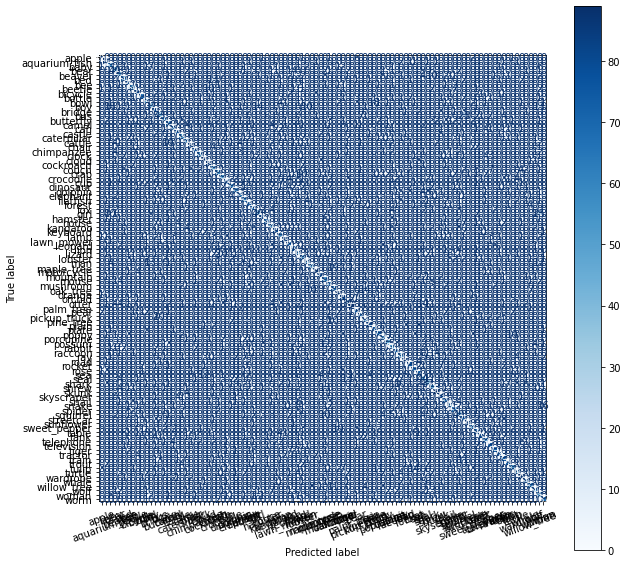

In [13]:
classes = test.classes

plot_confusion_matrix(labels, pred_labels, classes)

Text(0.5, 1.0, 'GoogLeNet, Cross Entropy Loss across Epochs')

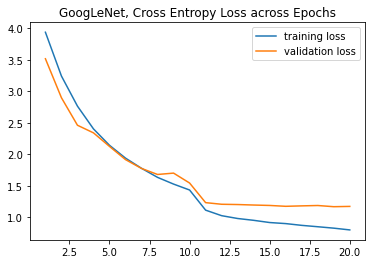

In [18]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_loss_list, label = 'training loss')
plt.plot([i for i in range(1,EPOCHS + 1)], val_loss_list, label = 'validation loss')
plt.legend()
plt.title('GoogLeNet, Cross Entropy Loss across Epochs')

Text(0.5, 1.0, 'GoogLeNet, Accuracy across Epochs')

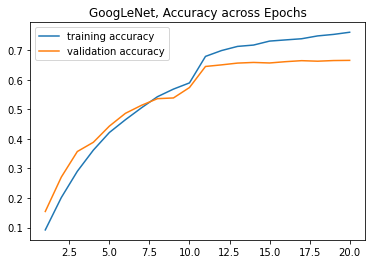

In [19]:
plt.plot([i for i in range(1,EPOCHS + 1)], train_acc_list, label = 'training accuracy')
plt.plot([i for i in range(1,EPOCHS + 1)], val_acc_list, label = 'validation accuracy')
plt.legend()
plt.title('GoogLeNet, Accuracy across Epochs')

In [20]:
def labels_accuracy(y, y_pred):
  crr = 0
  for i in range(len(y)):
    if y[i] == y_pred[i]:
      crr += 1
  return crr/len(y)

In [17]:
labels_accuracy(labels.numpy(), pred_labels.numpy())

0.6616

In [21]:
correct_pred = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, correct_pred):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [22]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

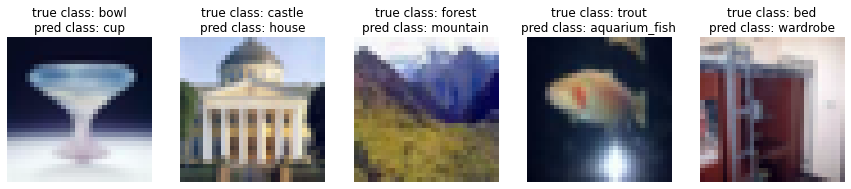

In [23]:
def show_incorrect_preds(incorrect, classes, n_images, normalize = True):

    rows = 1
    cols = n_images 

    fig = plt.figure(figsize = (15, 10))
    fig.tight_layout()
    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true class: {true_class}\n' \
                     f'pred class: {incorrect_class}')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.0)

show_incorrect_preds(incorrect_examples, classes, 5)

#CIFAR-100 dataset

##ResNet, VGG and GoogLeNet

In [5]:
# using pretrained means to normalize the dataset
pretrained_means = [0.4914, 0.4822, 0.4465]
pretrained_stds= [0.247, 0.243, 0.261]
BATCH_SIZE = 100


transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(pretrained_means, pretrained_stds)
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pretrained_means, pretrained_stds)
    ])

train = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# percentage of the training data to be used in training
TRAIN_VAL_RATIO = 0.90

n_train_examples = int(len(train) * TRAIN_VAL_RATIO)
n_valid_examples = len(train) - n_train_examples

train, val = torch.utils.data.random_split(train, [n_train_examples, n_valid_examples])

# applying the transform on validation set
val = copy.deepcopy(val)
val.dataset.transform = transform_test

# defining appropriate dataloaders
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [4]:
cfg = {
    'A' : [64,     'M', 128,      'M', 256, 256,           'M', 512, 512,           'M', 512, 512,           'M'],
    'B' : [64, 64, 'M', 128, 128, 'M', 256, 256,           'M', 512, 512,           'M', 512, 512,           'M'],
    'D' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256,      'M', 512, 512, 512,      'M', 512, 512, 512,      'M'],
    'E' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

class VGG(nn.Module):

    def __init__(self, features, num_class=100):
        super().__init__()
        self.features = features

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_class)
        )

    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size()[0], -1)
        output = self.classifier(output)

        return output

def make_layers(cfg, batch_norm=False):
    layers = []

    input_channel = 3
    for l in cfg:
        if l == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            continue

        layers += [nn.Conv2d(input_channel, l, kernel_size=3, padding=1)]

        if batch_norm:
            layers += [nn.BatchNorm2d(l)]

        layers += [nn.ReLU(inplace=True)]
        input_channel = l

    return nn.Sequential(*layers)

def vgg11_bn():
    return VGG(make_layers(cfg['A'], batch_norm=True))

def vgg13_bn():
    return VGG(make_layers(cfg['B'], batch_norm=True))

def vgg16_bn():
    return VGG(make_layers(cfg['D'], batch_norm=True))

def vgg19_bn():
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [3]:
class Inception(nn.Module):
    def __init__(self, input_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool_proj):
        super().__init__()

        #1x1conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True)
        )

        #1x1conv -> 3x3conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(input_channels, n3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(n3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3_reduce, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True)
        )

        #1x1conv -> 5x5conv branch
        #we use 2 3x3 conv filters stacked instead
        #of 1 5x5 filters to obtain the same receptive
        #field with fewer parameters
        self.b3 = nn.Sequential(
            nn.Conv2d(input_channels, n5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(n5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5_reduce, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5, n5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True)
        )

        #3x3pooling -> 1x1conv
        #same conv
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(input_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)


class GoogleNet(nn.Module):

    def __init__(self, num_class=100):
        super().__init__()
        self.prelayer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )

        #although we only use 1 conv layer as prelayer,
        #we still use name a3, b3.......
        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        ##"""In general, an Inception network is a network consisting of
        ##modules of the above type stacked upon each other, with occasional
        ##max-pooling layers with stride 2 to halve the resolution of the
        ##grid"""
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        #input feature size: 8*8*1024
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.linear = nn.Linear(1024, num_class)

    def forward(self, x):
        x = self.prelayer(x)
        x = self.maxpool(x)
        x = self.a3(x)
        x = self.b3(x)

        x = self.maxpool(x)

        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)

        x = self.maxpool(x)

        x = self.a5(x)
        x = self.b5(x)

        #"""It was found that a move from fully connected layers to
        #average pooling improved the top-1 accuracy by about 0.6%,
        #however the use of dropout remained essential even after
        #removing the fully connected layers."""
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)

        return x

def googlenet():
    return GoogleNet()

In [6]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# umcomment a model to use here

#model = vgg16_bn().to(device)

#model = resnet50().to(device)

model = googlenet().to(device)

print(model)

summary(model, (3, 32, 32))

GoogleNet(
  (prelayer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (a3): Inception(
    (b1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (b2): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(96, eps=1